This notebook shares EDA on the aggregate and phone level data, then trains a neural network model to predict the residuals of base estimations provided with aggregated features.

The contents of the notebook are organized as follows:
1. Aggregated Data EDA
2. Phone Level Data EDA
3. Feature Generation: generates aggregated features for training. Currently we only use previous lat/long and `correctedPrM` from derived files.
4. Model Training: trains a neural network with a skip connection in Keras on TPU.

Credits to other notebooks:
* [Baseline from host data](https://www.kaggle.com/jpmiller/baseline-from-host-data) by @jpmiller: for the distance calculation with `calc_haversine()`
* [Demonstration of the Kalman filter](https://www.kaggle.com/emaerthin/demonstration-of-the-kalman-filter) by @emaerthin: for Kalman filtering with `apply_kf_smoothing()`
* [Loading GNSS logs](https://www.kaggle.com/sohier/loading-gnss-logs) by organizers: for GNSS log loading with `gnss_log_to_dataframes()`
* [Ѫ Start Here: Simple Folium Heatmap for Geo-Data](https://www.kaggle.com/dannellyz/start-here-simple-folium-heatmap-for-geo-data) by @dannellyz: for geospatial heatmap with `simple_folium()`

Thanks for sharing.

# Load Libraries & Data

In [1]:
!pip install simdkalman

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np # linear algebra
from pathlib import Path
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import sparse
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import simdkalman
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from warnings import simplefilter

simplefilter('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [3]:
model_name = 'nn_v2'

data_dir = Path('../input/google-smartphone-decimeter-challenge')
train_file = data_dir / 'baseline_locations_train.csv'
test_file = data_dir / 'baseline_locations_test.csv'
sample_file = data_dir / 'sample_submission.csv'

build_dir = Path('./build')
build_dir.mkdir(parents=True, exist_ok=True)
predict_val_file = build_dir / f'{model_name}.val.txt'
predict_tst_file = build_dir / f'{model_name}.tst.txt'
submission_file = 'submission.csv'

cname_col = 'collectionName'
pname_col = 'phoneName'
phone_col = 'phone'
ts_col = 'millisSinceGpsEpoch'
dt_col = 'datetime'
lat_col = 'latDeg'
lon_col = 'lngDeg'

lrate = .001
batch_size = 1024
epochs = 100
n_stop = 10
n_fold = 5
seed = 42

In [4]:
# from https://www.kaggle.com/sohier/loading-gnss-logs
def gnss_log_to_dataframes(path):
    print('Loading ' + path, flush=True)
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [5]:
# from https://www.kaggle.com/dannellyz/start-here-simple-folium-heatmap-for-geo-data
import folium
from folium import plugins


def simple_folium(df:pd.DataFrame, lat_col:str, lon_col:str):
    """
    Descrption
    ----------
        Returns a simple Folium HeatMap with Markers
    ----------
    Parameters
    ----------
        df : padnas DataFrame, required
            The DataFrane with the data to map
        lat_col : str, required
            The name of the column with latitude
        lon_col : str, required
            The name of the column with longitude
    """
    #Preprocess
    #Drop rows that do not have lat/lon
    df = df[df[lat_col].notnull() & df[lon_col].notnull()]

    # Convert lat/lon to (n, 2) nd-array format for heatmap
    # Then send to list
    df_locs = list(df[[lat_col, lon_col]].values)

    #Set up folium map
    fol_map = folium.Map([df[lat_col].median(), df[lon_col].median()])

    # plot heatmap
    heat_map = plugins.HeatMap(df_locs)
    fol_map.add_child(heat_map)

    # plot markers
    markers = plugins.MarkerCluster(locations = df_locs)
    fol_map.add_child(markers)

    #Add Layer Control
    folium.LayerControl().add_to(fol_map)

    return fol_map

In [6]:
# from https://www.kaggle.com/jpmiller/baseline-from-host-data
# simplified haversine distance
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(a**0.5)
    dist = 6_367_000 * c
    return dist

In [7]:
# from https://www.kaggle.com/emaerthin/demonstration-of-the-kalman-filter
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[phone_col].unique()
    for phone in tqdm(unique_paths):
        data = df.loc[df[phone_col] == phone][[lat_col, lon_col]].values
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[df[phone_col] == phone, lat_col] = smoothed.states.mean[0, :, 0]
        df.loc[df[phone_col] == phone, lon_col] = smoothed.states.mean[0, :, 1]
    return df

In [8]:
trn = pd.read_csv(train_file)
print(trn.shape)
trn.head()

(131342, 7)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4


In [9]:
tst = pd.read_csv(test_file)
print(tst.shape)
tst.head()

(91486, 7)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
0,2020-05-15-US-MTV-1,Pixel4,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Pixel4
1,2020-05-15-US-MTV-1,Pixel4,1273608786432,37.416646,-122.082040,-31.76,2020-05-15-US-MTV-1_Pixel4
2,2020-05-15-US-MTV-1,Pixel4,1273608787432,37.416652,-122.082039,-31.65,2020-05-15-US-MTV-1_Pixel4
3,2020-05-15-US-MTV-1,Pixel4,1273608788432,37.416607,-122.082063,-31.52,2020-05-15-US-MTV-1_Pixel4
4,2020-05-15-US-MTV-1,Pixel4,1273608789432,37.416609,-122.082073,-28.95,2020-05-15-US-MTV-1_Pixel4


In [10]:
sub = pd.read_csv(sample_file)
print(sub.shape)
sub.head()

(91486, 4)


,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.904611,-86.481078
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.904611,-86.481078
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.904611,-86.481078
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.904611,-86.481078
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.904611,-86.481078


# Aggregated Data EDA

## `collectionName`, `phoneName`

In [11]:
for col in [cname_col, pname_col]:
    print(f'# of unique {col:>14s} in training: {trn[col].nunique():4d}')
    print(f'# of unique {col:>14s}     in test: {tst[col].nunique():4d}')

# of unique collectionName in training:   29
# of unique collectionName     in test:   19
# of unique      phoneName in training:    7
# of unique      phoneName     in test:    7


In [12]:
trn[pname_col].value_counts()

Pixel4             48153
Pixel4XL           27710
SamsungS20Ultra    14204
Mi8                14169
Pixel5             11791
Pixel4XLModded      8388
Pixel4Modded        6927
Name: phoneName, dtype: int64

In [13]:
tst[pname_col].value_counts()

Pixel4             29201
SamsungS20Ultra    17338
Pixel4XL           17084
Pixel5              9057
Pixel4XLModded      6790
Pixel4Modded        6209
Mi8                 5807
Name: phoneName, dtype: int64

In [14]:
print(f'# of unique phone in training: {trn[phone_col].nunique():4d}')
print(f'    # of unique phone in test: {tst[phone_col].nunique():4d}')

# of unique phone in training:   73
    # of unique phone in test:   48


In [15]:
trn[phone_col].value_counts()

2021-04-22-US-SJC-1_Pixel4             2890
2021-04-22-US-SJC-1_SamsungS20Ultra    2826
2020-09-04-US-SF-2_Mi8                 2500
2021-04-29-US-SJC-2_SamsungS20Ultra    2370
2020-09-04-US-SF-2_Pixel4              2349
2021-04-29-US-SJC-2_Pixel4             2330
2020-07-08-US-MTV-1_Pixel4             2232
2020-07-17-US-MTV-1_Mi8                2095
2021-04-28-US-SJC-1_SamsungS20Ultra    2083
2021-01-04-US-RWC-1_Pixel5             2076
2021-01-04-US-RWC-1_Pixel4             2075
2021-01-04-US-RWC-1_Pixel4XL           2071
2021-01-04-US-RWC-1_Pixel4Modded       2071
2020-06-05-US-MTV-1_Pixel4XL           2070
2020-05-21-US-MTV-1_Pixel4             2031
2021-04-28-US-SJC-1_Pixel4             2014
2020-08-03-US-MTV-1_Pixel4             2009
2020-05-29-US-MTV-2_Pixel4XL           2006
2020-05-29-US-MTV-2_Pixel4             2003
2021-04-28-US-MTV-1_Pixel4             1999
2020-06-11-US-MTV-1_Pixel4             1990
2021-04-28-US-MTV-1_Pixel5             1985
2021-04-28-US-MTV-1_SamsungS20Ul

In [16]:
tst[phone_col].value_counts()

2020-05-15-US-MTV-1_Pixel4XL           3517
2020-05-15-US-MTV-1_Pixel4             3488
2020-05-28-US-MTV-1_Pixel4XL           2426
2021-04-02-US-SJC-1_Pixel5             2385
2021-04-02-US-SJC-1_Pixel4             2364
2020-08-13-US-MTV-1_Mi8                2342
2021-03-16-US-MTV-2_SamsungS20Ultra    2326
2021-04-22-US-SJC-2_SamsungS20Ultra    2324
2021-04-26-US-SVL-2_SamsungS20Ultra    2324
2020-05-28-US-MTV-2_Pixel4             2318
2020-05-28-US-MTV-2_Pixel4XL           2309
2020-05-28-US-MTV-1_Pixel4             2256
2020-08-13-US-MTV-1_Pixel4             2245
2021-04-29-US-SJC-3_SamsungS20Ultra    2061
2021-03-16-US-MTV-2_Pixel4Modded       2041
2021-03-16-US-RWC-2_Pixel5             2010
2021-04-29-US-SJC-3_Pixel4             1979
2021-03-16-US-RWC-2_SamsungS20Ultra    1972
2021-03-16-US-RWC-2_Pixel4XL           1968
2020-06-10-US-MTV-2_Pixel4XLModded     1937
2020-06-10-US-MTV-2_Pixel4XL           1805
2020-06-10-US-MTV-2_Pixel4             1794
2021-04-28-US-MTV-2_SamsungS20Ul

Each phone has fair amount of data points ranging between 577 and 3,517.

In [17]:
overlapping_phones = [x for x in tst[phone_col] if x in trn[phone_col]]
print(len(overlapping_phones))

0


There's **no** overlapping phone between the training and test data.

## `millisSinceGpsEpoch`

In [18]:
tst[ts_col].min(), tst[ts_col].max()

(1273608752446, 1303772671000)

From the data description, `millisSinceGpsEpoch` is "an integer number of milliseconds since the GPS epoch (1980/1/6 midnight UTC). Its value equals". We can convert them to `datatime64` using `pd.to_datetime()` as follows:

In [19]:
dt_offset = pd.to_datetime('1980-01-06 00:00:00')
print(dt_offset)
dt_offset_in_ms = int(dt_offset.value / 1e6)

1980-01-06 00:00:00


In [20]:
trn[dt_col] = pd.to_datetime(trn[ts_col] + dt_offset_in_ms, unit='ms')
tst[dt_col] = pd.to_datetime(tst[ts_col] + dt_offset_in_ms, unit='ms')
print(f'Training data range: {trn[dt_col].min()} - {trn[dt_col].max()}')
print(f'    Test data range: {tst[dt_col].min()} - {tst[dt_col].max()}')

Training data range: 2020-05-14 22:11:03.442000 - 2021-04-29 22:29:23
    Test data range: 2020-05-15 20:12:32.446000 - 2021-04-29 23:04:31


## `latDeg` and `lngDeg`

First, let's see how estimated locations between the training and test data look like. The ground truth for training data is available per `phone` in `{collectionName}/{phoneName}/ground_truth.csv`.

In [21]:
latlon_trn = trn[[lat_col, lon_col]].round(3)
latlon_trn['counts'] = 1
latlon_trn = latlon_trn.groupby([lat_col, lon_col]).sum().reset_index()
latlon_trn.head()

,latDeg,lngDeg,counts
0,37.322,-121.891,1
1,37.323,-122.051,58
2,37.323,-122.050,38
3,37.323,-122.049,14
4,37.324,-122.051,12


Let's see the heatmap for the training data.

In [22]:
simple_folium(latlon_trn, lat_col, lon_col)

Let's see the heatmap for the test data too.

In [23]:
latlon_tst = tst[[lat_col, lon_col]].round(3)
latlon_tst['counts'] = 1
latlon_tst = latlon_tst.groupby([lat_col, lon_col]).sum().reset_index()

simple_folium(latlon_tst, lat_col, lon_col)

# Phone Level Data EDA

## GNSS Logs

In [24]:
cname = trn[cname_col][0]
pname = trn[pname_col][0]
dfs = gnss = gnss_log_to_dataframes(str(data_dir / 'train' / cname / pname / f'{pname}_GnssLog.txt'))
print(dfs.keys())

Loading ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/Pixel4_GnssLog.txt
dict_keys(['UncalAccel', 'Fix', 'UncalMag', 'OrientationDeg', 'Status', 'Raw', 'UncalGyro'])


In [25]:
df_raw = dfs['Raw']
print(df_raw.shape)
df_raw.head()

(57497, 29)


,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,Svid,TimeOffsetNanos,State,ReceivedSvTimeNanos,ReceivedSvTimeUncertaintyNanos,Cn0DbHz,PseudorangeRateMetersPerSecond,PseudorangeRateUncertaintyMetersPerSecond,AccumulatedDeltaRangeState,AccumulatedDeltaRangeMeters,AccumulatedDeltaRangeUncertaintyMeters,CarrierFrequencyHz,CarrierCycles,CarrierPhase,CarrierPhaseUncertainty,MultipathIndicator,SnrInDb,ConstellationType,AgcDb
0,1589494245442,21091250000000,NaN,NaN,-1273508372192433379,-0.173279,25.084462,-0.129289,10.603476,2593,2,0.0,16399,425463372262852,7,37.9,220.776733,0.0374,25,90376.660996,0.001009,1.575420e+09,NaN,NaN,NaN,0,NaN,1,-0.61
1,1589494245442,21091250000000,NaN,NaN,-1273508372192433379,-0.173279,25.084462,-0.129289,10.603476,2593,5,0.0,16399,425463365539137,14,30.0,-586.563171,0.0304,25,-230438.363201,0.002398,1.575420e+09,NaN,NaN,NaN,0,NaN,1,-0.61
2,1589494245442,21091250000000,NaN,NaN,-1273508372192433379,-0.173279,25.084462,-0.129289,10.603476,2593,6,0.0,16399,425463367955840,8,36.9,528.939148,0.0301,25,226566.869053,0.001161,1.575420e+09,NaN,NaN,NaN,0,NaN,1,-0.61
3,1589494245442,21091250000000,NaN,NaN,-1273508372192433379,-0.173279,25.084462,-0.129289,10.603476,2593,12,0.0,16399,425463375340210,24,25.2,-99.724022,0.0558,17,-50596.501663,0.190294,1.575420e+09,NaN,NaN,NaN,0,NaN,1,-0.61
4,1589494245442,21091250000000,NaN,NaN,-1273508372192433379,-0.173279,25.084462,-0.129289,10.603476,2593,19,0.0,16399,425463361953688,17,28.0,538.026794,0.0267,21,11022.585647,0.003007,1.575420e+09,NaN,NaN,NaN,0,NaN,1,-0.61


In [26]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57497 entries, 0 to 57496
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   utcTimeMillis                              57497 non-null  int64  
 1   TimeNanos                                  57497 non-null  int64  
 2   LeapSecond                                 0 non-null      float64
 3   TimeUncertaintyNanos                       0 non-null      float64
 4   FullBiasNanos                              57497 non-null  int64  
 5   BiasNanos                                  57497 non-null  float64
 6   BiasUncertaintyNanos                       57497 non-null  float64
 7   DriftNanosPerSecond                        57497 non-null  float64
 8   DriftUncertaintyNanosPerSecond             57497 non-null  float64
 9   HardwareClockDiscontinuityCount            57497 non-null  int64  
 10  Svid                  

From the [post](https://www.kaggle.com/c/google-smartphone-decimeter-challenge/discussion/238583) by @sohier and [slides](https://www.kaggle.com/google/android-smartphones-high-accuracy-datasets?select=ION+GNSS+2020+Slides+Android+Raw+GNSS+Measurement+Datasets+for+Precise+Positioning.pdf) by the data provider: 

Measurements from GNSS chipsets of mobile phones are often noisier and more erroneous. Example of filters your can apply (to exclude) are:
1. `FullBiasNanos` (GNSS Raw) is zero or invalid
2. `BiasUncertaintyNanos` (GNSS Raw) too large (> 1e6)
3. Arrival time is negative or unrealistically large - can be calculated from `rawPrM` (Derived)
4. Unknown constellation (`constellationType == 0`) (Derived, GNSS Raw)
5. `TimeNanos` is empty (GNSS Raw)
6. `State` is not in (`STATE_TOW_DECODED`, `STATE_TOW_KNOWN`, `STATE_GLO_TOD_DECODED`, `STATE_GLO_TOD_KNOWN`) (GNSS Raw)
7. `ReceivedSvTimeUncertaintyNanos` is high (500 ns) (GNSS Raw)
8. `AccumulatedDeltaRangeState` violating this condition: `ADR_STATE_VALID == 1 & ADR_STATE_RESET == 0 & ADR_STATE_CYCLE_SLIP == 0` (GNSS Raw)
9. `AccumulatedDeltaRangeUncertaintyMeters` is high (GNSS Raw)
10. `Cn0DbHz` is less than 20 db-Hz (GNSS Raw)

count    5.749700e+04
mean     1.273530e+18
std      4.950578e+11
min      1.273529e+18
25%      1.273530e+18
50%      1.273530e+18
75%      1.273531e+18
max      1.273531e+18
Name: ArrivalTime, dtype: float64


<AxesSubplot:>

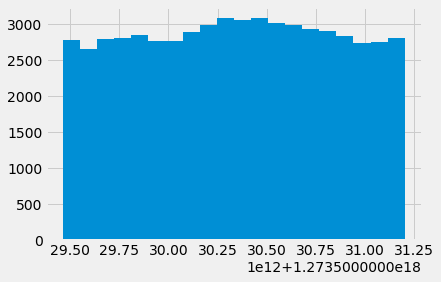

In [27]:
df_raw['ArrivalTime'] = df_raw['TimeNanos'] - df_raw['FullBiasNanos'] - df_raw['BiasNanos']
print(df_raw['ArrivalTime'].describe())
df_raw['ArrivalTime'].hist(bins=20)

count    57497.000000
mean        18.349364
std          3.134316
min         13.447537
25%         16.307911
50%         17.541317
75%         19.399104
max         37.495120
Name: BiasUncertaintyNanos, dtype: float64


<AxesSubplot:>

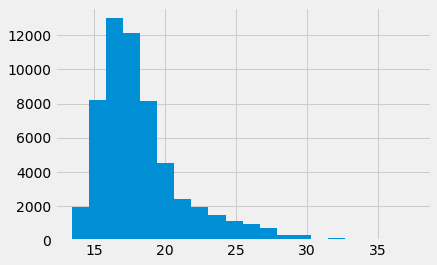

In [28]:
print(df_raw['BiasUncertaintyNanos'].describe())
df_raw['BiasUncertaintyNanos'].hist(bins=20)

count    57497.00000
mean        12.60511
std         13.10202
min          2.00000
25%          5.00000
50%          9.00000
75%         14.00000
max        181.00000
Name: ReceivedSvTimeUncertaintyNanos, dtype: float64


<AxesSubplot:>

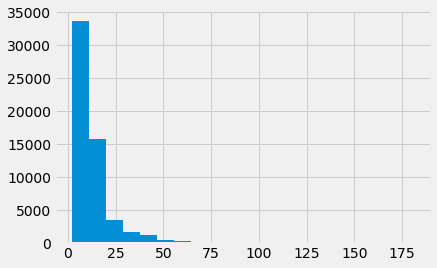

In [29]:
print(df_raw['ReceivedSvTimeUncertaintyNanos'].describe())
df_raw['ReceivedSvTimeUncertaintyNanos'].hist(bins=20)

count    57497.000000
mean         0.021948
std          0.067492
min          0.000000
25%          0.001009
50%          0.002188
75%          0.003771
max          0.345572
Name: AccumulatedDeltaRangeUncertaintyMeters, dtype: float64


<AxesSubplot:>

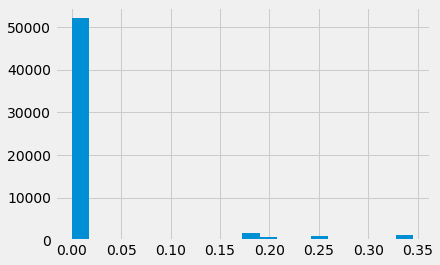

In [30]:
print(df_raw.AccumulatedDeltaRangeUncertaintyMeters.describe())
df_raw.AccumulatedDeltaRangeUncertaintyMeters.hist(bins=20)

count    57497.000000
mean        31.489198
std          6.088397
min          7.300000
25%         27.500000
50%         31.700000
75%         36.000000
max         45.300000
Name: Cn0DbHz, dtype: float64


<AxesSubplot:>

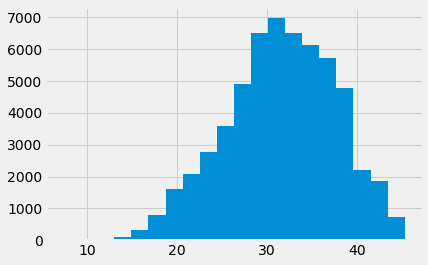

In [31]:
print(df_raw.Cn0DbHz.describe())
df_raw.Cn0DbHz.hist(bins=20)

In [32]:
df_raw = df_raw.loc[
    ~pd.isnull(df_raw.FullBiasNanos) &
    (df_raw.BiasUncertaintyNanos < 100) &
    (df_raw.ArrivalTime > 0) &
    (df_raw.ConstellationType != 0) &
    ~pd.isnull(df_raw.TimeNanos) &
    (df_raw.State != 3) & (df_raw.State != 14) & (df_raw.State != 7) & (df_raw.State != 15) &
    (df_raw.ReceivedSvTimeUncertaintyNanos < 100) &
    (df_raw.AccumulatedDeltaRangeUncertaintyMeters < 0.3) &
    (df_raw.Cn0DbHz > 20)
]
print(df_raw.shape)

(54129, 30)


See organizer's [Loading GNSS logs](https://www.kaggle.com/sohier/loading-gnss-logs) notebook for more details.

## Derived Values

Derived values are used to generate baseline location estimates in `baseline_locations_{train|test}.csv`.

In [33]:
derived = pd.read_csv(data_dir / 'train' / cname / pname / f'{pname}_derived.csv')
print(derived.shape)
derived.head()

(55218, 20)


,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
0,2020-05-14-US-MTV-1,Pixel4,1273529464442,3,24,GLO_G1,1273529463363061857,-2.539901e+07,-6.925122e+05,-2.280430e+06,-325.826,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,13,GAL_E1,1273529463363970742,-5.199894e+06,-1.741927e+07,2.336128e+07,2239.305,700.815,1022.014,120171.076,0.000,2.352251e+07,1.799,-222.675,3.946,2.717
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,1,5,GPS_L1,1273529463365539137,-2.179863e+06,-2.615488e+07,-3.437694e+06,325.541,-419.725,3129.012,-3793.067,-0.001,2.305231e+07,4.197,0.000,7.554,5.704
3,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,15,GAL_E1,1273529463352380595,1.635469e+07,-1.047833e+07,2.234460e+07,2172.409,561.971,-1326.001,259937.286,-0.000,2.699715e+07,8.094,-222.675,7.968,9.151
4,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,21,GAL_E1,1273529463364075083,-1.484042e+07,-2.110960e+07,1.449632e+07,-426.094,-1395.675,-2467.793,-179555.991,-0.001,2.349123e+07,2.698,-222.675,3.834,2.544


In [34]:
derived.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55218 entries, 0 to 55217
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   collectionName            55218 non-null  object 
 1   phoneName                 55218 non-null  object 
 2   millisSinceGpsEpoch       55218 non-null  int64  
 3   constellationType         55218 non-null  int64  
 4   svid                      55218 non-null  int64  
 5   signalType                55218 non-null  object 
 6   receivedSvTimeInGpsNanos  55218 non-null  int64  
 7   xSatPosM                  55218 non-null  float64
 8   ySatPosM                  55218 non-null  float64
 9   zSatPosM                  55218 non-null  float64
 10  xSatVelMps                55218 non-null  float64
 11  ySatVelMps                55218 non-null  float64
 12  zSatVelMps                55218 non-null  float64
 13  satClkBiasM               55218 non-null  float64
 14  satClk

In [35]:
derived = derived.loc[derived.constellationType != 0]
print(derived.shape)

(55218, 20)


Let's calculate `correctedPrM` as described in the data description:
```
correctedPrM = rawPrM + satClkBiasM - isrbM - ionoDelayM - tropoDelayM
```
"The baseline locations are computed using correctedPrM and the satellite positions, using a standard Weighted Least Squares (WLS) solver, with the phone's position (x, y, z), clock bias (t), and isrbM for each unique signal type as states for each epoch."

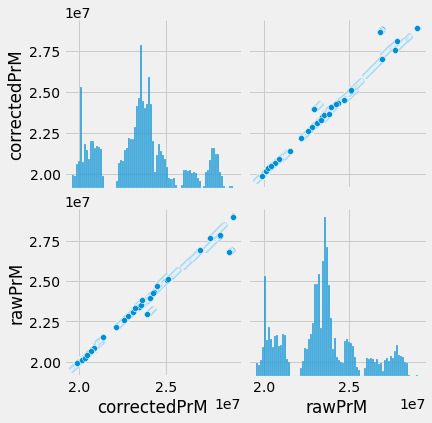

In [36]:
derived['correctedPrM'] = (derived['rawPrM'] + derived['satClkBiasM'] - derived['isrbM'] - 
                           derived['ionoDelayM'] - derived['tropoDelayM'])
sns.pairplot(data=derived, vars=['correctedPrM', 'rawPrM'], size=3)

In [37]:
derived[dt_col] = pd.to_datetime(derived[ts_col] + dt_offset_in_ms, unit='ms')
print(f'Data range for {cname}/{pname}: {derived[dt_col].min()} - {derived[dt_col].max()}')

Data range for 2020-05-14-US-MTV-1/Pixel4: 2020-05-14 22:11:04.442000 - 2020-05-14 22:40:02.442000


The data is for 30 minutes or 1,800 seconds. However, we have a lot more samples (55K). This is because, for each second, there are multiple samples with different `constellationType`, `svid`, and `signalType`.

In [38]:
derived[['constellationType', 'svid', 'signalType']].value_counts()

constellationType  svid  signalType
1                  12    GPS_L1        1737
                   2     GPS_L1        1735
3                  12    GLO_G1        1735
6                  1     GAL_E1        1735
                   21    GAL_E1        1734
                   13    GAL_E5A       1734
3                  23    GLO_G1        1734
1                  6     GPS_L1        1733
                   29    GPS_L1        1726
                   5     GPS_L1        1724
6                  13    GAL_E1        1723
1                  24    GPS_L5        1716
                   25    GPS_L5        1710
                   6     GPS_L5        1700
3                  22    GLO_G1        1685
1                  25    GPS_L1        1658
6                  27    GAL_E1        1632
3                  24    GLO_G1        1596
                   11    GLO_G1        1577
6                  1     GAL_E5A       1532
                   15    GAL_E1        1508
3                  7     GLO_G1        1

In [39]:
derived[[ts_col, 'constellationType', 'correctedPrM']].groupby([ts_col, 'constellationType']).agg(['mean', 'std', 'count']).describe()

correctedPrM                           
               mean           std        count
count  5.217000e+03  5.216000e+03  5217.000000
mean   2.329749e+07  1.672480e+06    10.584244
std    1.487690e+06  2.015742e+05     2.076066
min    2.075647e+07  4.045399e+05     1.000000
25%    2.218189e+07  1.606153e+06     9.000000
50%    2.249616e+07  1.722487e+06    11.000000
75%    2.521403e+07  1.817703e+06    12.000000
max    2.750292e+07  2.326849e+06    22.000000

In [40]:
derived.loc[derived.constellationType == 1][[ts_col, 'svid', 'correctedPrM']].groupby([ts_col, 'svid']).agg(['mean', 'std', 'count']).describe()

correctedPrM                           
               mean          std         count
count  1.447100e+04  4729.000000  14471.000000
mean   2.248439e+07     2.393364      1.327206
std    1.536132e+06     3.699112      0.470533
min    2.010396e+07     0.000000      1.000000
25%    2.108078e+07     0.641346      1.000000
50%    2.267056e+07     1.414921      1.000000
75%    2.345761e+07     2.798729      2.000000
max    2.566936e+07   111.511447      4.000000

Each epoch, given the constellation type of `1` (or GPS), from the same satellite, `coorectedPrM` can be different - because of different signal types.

In [41]:
derived.loc[derived.signalType == 'GPS_L1'][[ts_col, 'svid', 'correctedPrM']].groupby([ts_col, 'svid']).agg(['mean', 'std', 'count'])

correctedPrM           
                                  mean  std count
millisSinceGpsEpoch svid                         
1273529464442       2     2.089991e+07  NaN     1
                    5     2.304851e+07  NaN     1
                    6     2.224638e+07  NaN     1
                    12    2.014936e+07  NaN     1
                    19    2.407959e+07  NaN     1
...                                ...  ...   ...
1273531202442       19    2.504678e+07  0.0     2
                    24    2.422893e+07  0.0     2
                    25    2.066845e+07  0.0     2
                    29    2.257454e+07  0.0     2
                    31    2.509743e+07  0.0     2

[14072 rows x 3 columns]

In [42]:
derived.loc[derived.signalType == 'GPS_L1'][[ts_col, 'svid', 'correctedPrM']].groupby([ts_col, 'svid']).agg(['mean', 'std', 'count']).describe()

correctedPrM                   
               mean  std         count
count  1.407200e+04  8.0  14072.000000
mean   2.246564e+07  0.0      1.000569
std    1.542407e+06  0.0      0.023837
min    2.010396e+07  0.0      1.000000
25%    2.107048e+07  0.0      1.000000
50%    2.264993e+07  0.0      1.000000
75%    2.340820e+07  0.0      1.000000
max    2.566936e+07  0.0      2.000000

Each epoch, given the signal type of `GPS_L1`, from the same satellite, `correctedPrM` is unique.

In [43]:
derived.loc[derived.signalType == 'GPS_L1'][[ts_col, 'svid']].drop_duplicates().groupby([ts_col]).agg(['mean', 'std', 'count']).describe()

svid                          
              mean          std        count
count  1739.000000  1739.000000  1739.000000
mean     15.839069    10.883819     8.092007
std       1.189179     0.514523     0.818823
min       8.666667     9.073772     3.000000
25%      15.250000    10.361329     8.000000
50%      16.000000    11.022704     8.000000
75%      17.000000    11.022704     9.000000
max      21.000000    16.196707     9.000000

Each epoch, given the signal type of `GPS_L1`, there are signals from at least 3 satellites.

In [44]:
gps_l1 = derived.loc[derived.signalType == 'GPS_L1'][[ts_col, 'svid', 'correctedPrM']].drop_duplicates([ts_col, 'svid'])
print(gps_l1.shape)
gps_l1.head()

(14072, 3)


,millisSinceGpsEpoch,svid,correctedPrM
2,1273529464442,5,2.304851e+07
9,1273529464442,19,2.407959e+07
11,1273529464442,25,2.131610e+07
13,1273529464442,29,2.334908e+07
14,1273529464442,2,2.089991e+07


## Ground Truth

In [45]:
label = pd.read_csv(data_dir / 'train' / cname / pname / 'ground_truth.csv')
print(label.shape)
label.head()

(1740, 11)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423576,-122.094132,33.21,551.44,1.1,0.0,0.0,12.7
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423576,-122.094132,33.21,552.44,1.1,0.0,0.0,12.7
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423576,-122.094132,33.21,553.44,1.1,0.0,0.0,12.7
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423576,-122.094132,33.20,554.44,1.1,0.0,0.0,12.7
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423576,-122.094132,33.20,555.44,1.1,0.0,0.0,12.7


In the `*derived.csv`, we have 55K rows, but in the `ground_truth.csv`, we only have 1,740 rows.

In [46]:
label[dt_col] = pd.to_datetime(label[ts_col] + dt_offset_in_ms, unit='ms')
print(f'Labels range for {cname}/{pname}: {label[dt_col].min()} - {label[dt_col].max()}')

Labels range for 2020-05-14-US-MTV-1/Pixel4: 2020-05-14 22:11:03.442000 - 2020-05-14 22:40:02.442000


Hmm, this is weird. The label data starts 1 second earlier than the derived data. This means that if we join the derived and label data, the first second will have NaNs for derived columns. Let's check another phone data.

In [47]:
cname = trn[cname_col][10]
pname = trn[pname_col][10]
derived2 = pd.read_csv(data_dir / 'train' / cname / pname / f'{pname}_derived.csv')
label2 = pd.read_csv(data_dir / 'train' / cname / pname / 'ground_truth.csv')
print(f"Derived data starts at: {pd.to_datetime(derived2[ts_col].min() + dt_offset_in_ms, unit='ms')}")
print(f"  Label data starts at: {pd.to_datetime(label2[ts_col].min() + dt_offset_in_ms, unit='ms')}")

Derived data starts at: 2020-05-14 22:11:04.442000
  Label data starts at: 2020-05-14 22:11:03.442000


It's the same. We don't have the first second data in the derived data. Let's take a note and move on.

# Feature Generation

## Label Data Aggregation

First, let's add previous latitude and longitude estimates as features.

In [48]:
trn.sort_values([phone_col, ts_col], inplace=True)
trn[['prev_lat']] = trn[lat_col].shift().where(trn[phone_col].eq(trn[phone_col].shift()))
trn[['prev_lon']] = trn[lon_col].shift().where(trn[phone_col].eq(trn[phone_col].shift()))

tst.sort_values([phone_col, ts_col], inplace=True)
tst[['prev_lat']] = tst[lat_col].shift().where(tst[phone_col].eq(tst[phone_col].shift()))
tst[['prev_lon']] = tst[lon_col].shift().where(tst[phone_col].eq(tst[phone_col].shift()))
trn.head()

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,datetime,prev_lat,prev_lon
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,2020-05-14 22:11:03.442,NaN,NaN
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,2020-05-14 22:11:04.442,37.423575,-122.094091
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,2020-05-14 22:11:05.442,37.423578,-122.094101
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,2020-05-14 22:11:06.442,37.423573,-122.094111
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,2020-05-14 22:11:07.442,37.423583,-122.094121


In [49]:
# from https://www.kaggle.com/jpmiller/baseline-from-host-data
label_files = (data_dir / 'train').rglob('ground_truth.csv')
cols = [phone_col, ts_col, lat_col, lon_col]

df_list = []
for t in tqdm(label_files, total=73):
    label = pd.read_csv(t, usecols=[cname_col, pname_col, ts_col, lat_col, lon_col])
    df_list.append(label)

df_label = pd.concat(df_list, ignore_index=True)
df_label[phone_col] = df_label[cname_col] + '_' + df_label[pname_col]

df = df_label.merge(trn[cols + ['prev_lat', 'prev_lon']], how='inner', on=[phone_col, ts_col], 
                    suffixes=('_gt', '')).drop([cname_col, pname_col], axis=1)
df['sSinceGpsEpoch'] = df[ts_col] // 1000
print(df.shape)
df.head()

  0%|          | 0/73 [00:00<?, ?it/s]

(131342, 9)


,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,phone,latDeg,lngDeg,prev_lat,prev_lon,sSinceGpsEpoch
0,1279059935000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428288,-122.072583,NaN,NaN,1279059935
1,1279059936000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428271,-122.072521,37.428288,-122.072583,1279059936
2,1279059937000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428234,-122.072572,37.428271,-122.072521,1279059937
3,1279059938000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428260,-122.072544,37.428234,-122.072572,1279059938
4,1279059939000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428266,-122.072531,37.428260,-122.072544,1279059939


In [50]:
df_tst = sub[[phone_col, ts_col]].merge(tst[[phone_col, ts_col, lat_col, lon_col, 'prev_lat', 'prev_lon']], 
                                        how='left', on=[phone_col, ts_col], suffixes=('', '_basepred'))
df_tst['sSinceGpsEpoch'] = df_tst[ts_col] // 1000
print(df_tst.shape)
df_tst.head()

(91486, 7)


,phone,millisSinceGpsEpoch,latDeg,lngDeg,prev_lat,prev_lon,sSinceGpsEpoch
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.416628,-122.082053,NaN,NaN,1273608785
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.416646,-122.082040,37.416628,-122.082053,1273608786
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.416652,-122.082039,37.416646,-122.082040,1273608787
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.416607,-122.082063,37.416652,-122.082039,1273608788
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.416609,-122.082073,37.416607,-122.082063,1273608789


## Derived Data Aggregation

In [51]:
derived_files = (data_dir / 'train').rglob('*_derived.csv')
cols = [ts_col, 'svid', 'correctedPrM']

df_list = []
for t in tqdm(derived_files, total=73):
    derived = pd.read_csv(t).drop_duplicates([ts_col, 'svid'])
    derived['correctedPrM'] = (derived['rawPrM'] + derived['satClkBiasM'] - derived['isrbM'] - 
                               derived['ionoDelayM'] - derived['tropoDelayM'])
    df_list.append(derived[[cname_col, pname_col, ts_col, 'svid', 'correctedPrM']])
    
df_derived = pd.concat(df_list, ignore_index=True)
df_derived[phone_col] = df_derived[cname_col] + '_' + df_derived[pname_col]
df_derived.drop([cname_col, pname_col], axis=1, inplace=True)

print(df_derived.shape)
df_derived.head()

  0%|          | 0/73 [00:00<?, ?it/s]

(2350561, 4)


,millisSinceGpsEpoch,svid,correctedPrM,phone
0,1279059936000,24,2.027206e+07,2020-07-17-US-MTV-1_Mi8
1,1279059936000,13,2.366362e+07,2020-07-17-US-MTV-1_Mi8
2,1279059936000,32,2.231625e+07,2020-07-17-US-MTV-1_Mi8
3,1279059936000,21,2.706490e+07,2020-07-17-US-MTV-1_Mi8
4,1279059936000,17,2.019987e+07,2020-07-17-US-MTV-1_Mi8


In [52]:
df_derived_pivot = pd.pivot_table(df_derived, 
                                  values='correctedPrM', 
                                  index=[phone_col, ts_col],
                                  columns=['svid'],
                                  aggfunc=np.mean)
df_derived_pivot.columns = [f'svid_{x}' for x in df_derived_pivot.columns]
df_derived_pivot.reset_index(inplace=True)
df_derived_pivot['sSinceGpsEpoch'] = df_derived_pivot[ts_col] // 1000

print(df_derived_pivot.shape)
df_derived_pivot.head()

(130339, 40)


,phone,millisSinceGpsEpoch,svid_1,svid_2,svid_3,svid_4,svid_5,svid_6,svid_7,svid_8,svid_9,svid_10,svid_11,svid_12,svid_13,svid_14,svid_15,svid_16,svid_17,svid_18,svid_19,svid_20,svid_21,svid_22,svid_23,svid_24,svid_25,svid_26,svid_27,svid_28,svid_29,svid_30,svid_31,svid_32,svid_33,svid_34,svid_35,svid_36,svid_37,sSinceGpsEpoch
0,2020-05-14-US-MTV-1_Pixel4,1273529464442,2.507294e+07,2.089991e+07,NaN,NaN,2.304851e+07,2.224638e+07,NaN,NaN,NaN,NaN,2.275315e+07,2.014936e+07,2.364289e+07,NaN,2.725729e+07,NaN,NaN,NaN,2.407959e+07,NaN,2.331189e+07,2.014536e+07,2.078730e+07,2.379335e+07,2.131610e+07,2.422999e+07,2.599059e+07,NaN,2.334908e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1273529464
1,2020-05-14-US-MTV-1_Pixel4,1273529465442,2.507256e+07,2.090013e+07,NaN,NaN,2.304792e+07,2.224691e+07,NaN,NaN,NaN,NaN,2.275395e+07,2.014929e+07,2.364311e+07,NaN,2.725779e+07,NaN,NaN,NaN,2.408013e+07,NaN,2.331199e+07,2.014577e+07,2.078695e+07,2.379278e+07,2.131566e+07,2.422972e+07,2.599110e+07,NaN,2.334862e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1273529465
2,2020-05-14-US-MTV-1_Pixel4,1273529466442,2.507216e+07,2.090035e+07,NaN,NaN,2.304734e+07,2.224744e+07,NaN,NaN,NaN,NaN,2.275478e+07,2.014919e+07,2.364333e+07,NaN,2.725827e+07,NaN,NaN,NaN,2.408068e+07,NaN,2.331209e+07,2.014615e+07,2.078660e+07,2.379217e+07,2.131523e+07,2.422946e+07,2.599160e+07,NaN,2.334817e+07,NaN,NaN,NaN,2.836078e+07,NaN,NaN,NaN,NaN,1273529466
3,2020-05-14-US-MTV-1_Pixel4,1273529467442,2.507177e+07,2.090058e+07,NaN,NaN,2.304676e+07,2.224797e+07,NaN,NaN,NaN,NaN,2.275558e+07,2.014909e+07,2.364354e+07,NaN,2.725876e+07,NaN,NaN,NaN,2.408122e+07,NaN,2.331219e+07,2.014652e+07,2.078627e+07,2.379161e+07,2.131480e+07,2.422919e+07,2.599212e+07,NaN,2.334772e+07,NaN,NaN,NaN,2.836028e+07,NaN,NaN,NaN,NaN,1273529467
4,2020-05-14-US-MTV-1_Pixel4,1273529468442,2.507138e+07,2.090080e+07,NaN,NaN,2.304616e+07,2.224850e+07,NaN,NaN,NaN,NaN,2.275640e+07,2.014899e+07,2.364376e+07,NaN,2.725925e+07,NaN,NaN,NaN,2.408178e+07,NaN,2.331230e+07,2.014690e+07,NaN,2.379099e+07,2.131437e+07,2.422893e+07,2.599263e+07,NaN,2.334726e+07,NaN,NaN,NaN,2.835980e+07,NaN,NaN,NaN,NaN,1273529468


In [53]:
df = df.merge(df_derived_pivot, how='left', on=[phone_col, 'sSinceGpsEpoch'], suffixes=['', '_2'])
df.drop(['sSinceGpsEpoch', ts_col + '_2'], axis=1, inplace=True)
print(df.shape)
df.head()

(131347, 45)


,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,phone,latDeg,lngDeg,prev_lat,prev_lon,svid_1,svid_2,svid_3,svid_4,svid_5,svid_6,svid_7,svid_8,svid_9,svid_10,svid_11,svid_12,svid_13,svid_14,svid_15,svid_16,svid_17,svid_18,svid_19,svid_20,svid_21,svid_22,svid_23,svid_24,svid_25,svid_26,svid_27,svid_28,svid_29,svid_30,svid_31,svid_32,svid_33,svid_34,svid_35,svid_36,svid_37
0,1279059935000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428288,-122.072583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1279059936000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428271,-122.072521,37.428288,-122.072583,2.685321e+07,1.970457e+07,2.319984e+07,NaN,NaN,NaN,2.528679e+07,NaN,NaN,2.252299e+07,NaN,NaN,2.366362e+07,NaN,NaN,2.317906e+07,2.019987e+07,NaN,NaN,2.225647e+07,2.706490e+07,NaN,NaN,2.027206e+07,NaN,2.288696e+07,NaN,NaN,2.189129e+07,NaN,NaN,2.231625e+07,NaN,NaN,NaN,NaN,NaN
2,1279059937000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428234,-122.072572,37.428271,-122.072521,2.685341e+07,1.970418e+07,2.319903e+07,NaN,NaN,NaN,2.528629e+07,NaN,NaN,2.252248e+07,NaN,NaN,2.366365e+07,NaN,NaN,2.317894e+07,2.019952e+07,NaN,NaN,2.059899e+07,2.706540e+07,NaN,NaN,2.027227e+07,NaN,2.288725e+07,NaN,NaN,2.189181e+07,NaN,NaN,2.231651e+07,NaN,NaN,NaN,NaN,NaN
3,1279059938000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428260,-122.072544,37.428234,-122.072572,2.685361e+07,1.970380e+07,2.319821e+07,NaN,NaN,NaN,2.528579e+07,NaN,NaN,2.252197e+07,NaN,NaN,2.366370e+07,NaN,NaN,2.317883e+07,2.019916e+07,2.059086e+07,NaN,2.059878e+07,2.706590e+07,NaN,NaN,2.027251e+07,NaN,2.288755e+07,NaN,NaN,NaN,NaN,NaN,2.231678e+07,NaN,NaN,NaN,NaN,NaN
4,1279059939000,37.428281,-122.072541,2020-07-17-US-MTV-1_Mi8,37.428266,-122.072531,37.428260,-122.072544,2.685380e+07,1.970342e+07,2.319738e+07,NaN,NaN,NaN,2.528530e+07,NaN,NaN,2.252146e+07,NaN,NaN,2.366373e+07,NaN,NaN,2.317871e+07,2.019879e+07,2.059088e+07,NaN,2.059856e+07,2.706640e+07,NaN,NaN,2.027274e+07,NaN,2.288784e+07,NaN,NaN,NaN,NaN,NaN,2.231704e+07,NaN,NaN,NaN,NaN,NaN


In [54]:
df['d_lat'] = df['latDeg_gt'] - df[lat_col]
df['d_lon'] = df['lngDeg_gt'] - df[lon_col]
df[['d_lat', 'd_lon']].describe()

,d_lat,d_lon
count,131347.000000,1.313470e+05
mean,-0.000004,-1.219788e-06
std,0.000166,2.826426e-04
min,-0.019956,-5.527495e-02
25%,-0.000014,-1.253985e-05
50%,-0.000004,5.923000e-07
75%,0.000006,1.435370e-05
max,0.049745,7.093736e-02


In [55]:
derived_files = (data_dir / 'test').rglob('*_derived.csv')
cols = [ts_col, 'svid', 'correctedPrM']

df_list = []
for t in tqdm(derived_files, total=48):
    derived = pd.read_csv(t)
    derived['sSinceGpsEpoch'] = derived[ts_col] // 1000
    derived.drop_duplicates(['sSinceGpsEpoch', 'svid'], inplace=True)
    derived['correctedPrM'] = (derived['rawPrM'] + derived['satClkBiasM'] - derived['isrbM'] - 
                               derived['ionoDelayM'] - derived['tropoDelayM'])
    df_list.append(derived[[cname_col, pname_col, 'sSinceGpsEpoch', 'svid', 'correctedPrM']])
    
df_derived = pd.concat(df_list, ignore_index=True)
df_derived[phone_col] = df_derived[cname_col] + '_' + df_derived[pname_col]
df_derived.drop([cname_col, pname_col], axis=1, inplace=True)

df_derived_pivot = pd.pivot_table(df_derived, 
                                  values='correctedPrM', 
                                  index=[phone_col, 'sSinceGpsEpoch'],
                                  columns=['svid'],
                                  aggfunc=np.mean)
df_derived_pivot.columns = [f'svid_{x}' for x in df_derived_pivot.columns]
df_derived_pivot.reset_index(inplace=True)

df_tst = df_tst.merge(df_derived_pivot, how='left', 
                      on=[phone_col, 'sSinceGpsEpoch']).drop(['sSinceGpsEpoch'], axis=1)
print(df_tst.shape)
df_tst.head()

  0%|          | 0/48 [00:00<?, ?it/s]

(91486, 43)


,phone,millisSinceGpsEpoch,latDeg,lngDeg,prev_lat,prev_lon,svid_1,svid_2,svid_3,svid_4,svid_5,svid_6,svid_7,svid_8,svid_9,svid_10,svid_11,svid_12,svid_13,svid_14,svid_15,svid_16,svid_17,svid_18,svid_19,svid_20,svid_21,svid_22,svid_23,svid_24,svid_25,svid_26,svid_27,svid_28,svid_29,svid_30,svid_31,svid_32,svid_33,svid_34,svid_35,svid_36,svid_37
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.416628,-122.082053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.416646,-122.082040,37.416628,-122.082053,NaN,2.162738e+07,NaN,NaN,NaN,2.078516e+07,NaN,NaN,NaN,NaN,2.659049e+07,2.248163e+07,NaN,NaN,NaN,NaN,2.275734e+07,NaN,2.078783e+07,NaN,NaN,1.971513e+07,2.034109e+07,2.106731e+07,2.553178e+07,NaN,NaN,2.387446e+07,NaN,2.549334e+07,NaN,NaN,NaN,NaN,NaN,2.350364e+07,NaN
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.416652,-122.082039,37.416646,-122.082040,NaN,2.162693e+07,NaN,NaN,NaN,2.078498e+07,NaN,NaN,NaN,NaN,2.659098e+07,2.248115e+07,NaN,NaN,NaN,NaN,2.275781e+07,NaN,2.078818e+07,NaN,NaN,1.971554e+07,2.034062e+07,2.106725e+07,2.553215e+07,NaN,NaN,2.387486e+07,NaN,2.549292e+07,NaN,NaN,NaN,NaN,NaN,2.350371e+07,NaN
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.416607,-122.082063,37.416652,-122.082039,NaN,2.162650e+07,NaN,NaN,NaN,2.078479e+07,NaN,NaN,NaN,NaN,2.659147e+07,2.248064e+07,NaN,NaN,NaN,NaN,2.275828e+07,NaN,2.078853e+07,NaN,2.388174e+07,1.971595e+07,2.034014e+07,2.106719e+07,2.553251e+07,NaN,NaN,2.387527e+07,NaN,2.549251e+07,NaN,NaN,NaN,NaN,NaN,2.350377e+07,NaN
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.416609,-122.082073,37.416607,-122.082063,NaN,2.162604e+07,NaN,NaN,NaN,2.078461e+07,NaN,NaN,NaN,NaN,2.659197e+07,2.248017e+07,NaN,NaN,NaN,NaN,2.275876e+07,NaN,2.078889e+07,NaN,NaN,1.971636e+07,2.033966e+07,2.106713e+07,2.553287e+07,NaN,NaN,2.387567e+07,NaN,2.549210e+07,NaN,NaN,NaN,NaN,NaN,2.350384e+07,NaN


In [56]:
df_tst.describe()

,millisSinceGpsEpoch,latDeg,lngDeg,prev_lat,prev_lon,svid_1,svid_2,svid_3,svid_4,svid_5,svid_6,svid_7,svid_8,svid_9,svid_10,svid_11,svid_12,svid_13,svid_14,svid_15,svid_16,svid_17,svid_18,svid_19,svid_20,svid_21,svid_22,svid_23,svid_24,svid_25,svid_26,svid_27,svid_28,svid_29,svid_30,svid_31,svid_32,svid_33,svid_34,svid_35,svid_36,svid_37
count,9.148600e+04,91486.000000,91486.000000,91438.000000,91438.000000,2.625300e+04,7.794200e+04,1.772700e+04,1.470300e+04,4.396100e+04,7.014300e+04,2.033000e+04,2.580200e+04,2.024600e+04,2.164700e+04,3.301200e+04,7.854100e+04,6.947000e+04,5.386000e+04,7.227900e+04,3.345100e+04,5.547800e+04,4.368500e+04,7.257000e+04,3.612100e+04,7.053000e+04,2.611600e+04,4.124800e+04,6.842900e+04,5.209100e+04,3.424900e+04,6.908400e+04,5.131500e+04,3.529800e+04,7.115900e+04,2.635700e+04,1.288000e+04,1.848600e+04,6.516000e+03,6.480000e+03,4.071700e+04,1.595500e+04
mean,1.289832e+12,37.453128,-122.154313,37.453132,-122.154319,2.512481e+07,2.323402e+07,2.472681e+07,2.253018e+07,2.231553e+07,2.502293e+07,2.399100e+07,2.543262e+07,2.204315e+07,2.076274e+07,2.433640e+07,2.186801e+07,2.449531e+07,2.290240e+07,2.436503e+07,2.641229e+07,2.243677e+07,2.170580e+07,2.227812e+07,2.170834e+07,2.435773e+07,2.210982e+07,2.218898e+07,2.203919e+07,2.406403e+07,2.471117e+07,2.439363e+07,2.289694e+07,2.315347e+07,2.440937e+07,2.527567e+07,2.268571e+07,2.531991e+07,2.433433e+07,2.295754e+07,2.408187e+07,2.237680e+07
std,1.296896e+10,0.093020,0.146901,0.093023,0.146900,4.156925e+06,3.139017e+06,2.015056e+06,1.743503e+06,1.511580e+06,7.384830e+06,2.130232e+06,1.952483e+06,2.166823e+06,5.198553e+05,2.652525e+06,1.509499e+06,2.080348e+06,1.917812e+06,2.197097e+06,8.553284e+06,1.309186e+06,1.776985e+06,2.026527e+06,2.004951e+06,2.489223e+06,1.811470e+06,1.672699e+06,1.832978e+06,2.378084e+06,1.751982e+06,1.567771e+06,1.211998e+06,1.237652e+06,1.729675e+06,7.810247e+05,1.885044e+06,1.584314e+06,2.109951e+06,1.349815e+06,1.526737e+06,5.251804e+05
min,1.273609e+12,37.328368,-122.433247,37.328368,-122.433247,2.331093e+07,2.043125e+07,2.094309e+07,1.980813e+07,1.941194e+07,1.978160e+07,2.099674e+07,2.221941e+07,1.917830e+07,1.973783e+07,1.982209e+07,1.926299e+07,1.926350e+07,1.927331e+07,1.932529e+07,1.995992e+07,1.918009e+07,1.926168e+07,1.941284e+07,1.925065e+07,1.991290e+07,1.937567e+07,1.913534e+07,1.924841e+07,2.037890e+07,2.289868e+07,2.136496e+07,2.074541e+07,2.033203e+07,2.037101e+07,2.424455e+07,2.030466e+07,2.207255e+07,2.160511e+07,2.158889e+07,2.161599e+07,2.175505e+07
25%,1.275847e+12,37.386699,-122.270216,37.386694,-122.270244,2.334232e+07,2.124436e+07,2.344416e+07,2.028167e+07,2.134174e+07,2.075767e+07,2.183897e+07,2.357639e+07,2.001174e+07,2.039858e+07,2.234537e+07,2.043522e+07,2.347894e+07,2.148264e+07,2.358261e+07,2.044159e+07,2.176404e+07,2.007423e+07,2.074337e+07,1.968423e+07,2.230691e+07,2.029454e+07,2.150514e+07,2.071270e+07,2.177344e+07,2.351005e+07,2.356752e+07,2.181855e+07,2.207419e+07,2.345934e+07,2.482266e+07,2.042894e+07,2.441729e+07,2.164051e+07,2.173577e+07,2.346877e+07,2.201125e+07
50%,1.299958e+12,37.424149,-122.109190,37.424151,-122.109249,2.432666e+07,2.192425e+07,2.556986e+07,2.366448e+07,2.232425e+07,2.155571e+07,2.338747e+07,2.462619e+07,2.244429e+07,2.084021e+07,2.484942e+07,2.172884e+07,2.427300e+07,2.341085e+07,2.399895e+07,2.202407e+07,2.276581e+07,2.135311e+07,2.145942e+07,2.139451e+07,2.475950e+07,2.201770e+07,2.213939e+07,2.118011e+07,2.461278e+07,2.380615e+07,2.403212e+07,2.303987e+07,2.277387e+07,2.435736e+07,2.515764e+07,2.337077e+07,2.477849e+07,2.489317e+07,2.250984e+07,2.397128e+07,2.228867e+07
75%,1.301953e+12,37.495700,-122.079975,37.495712,-122.079975,2.469647e+07,2.414964e+07,2.598216e+07,2.380043e+07,2.331574e+07,2.385161e+07,2.586074e+07,2.767527e+07,2.393010e+07,2.103068e+07,2.643198e+07,2.262707e+07,2.632563e+07,2.424182e+07,2.530535e+07,2.531000e+07,2.335050e+07,2.314793e+07,2.415645e+07,2.330491e+07,2.648717e+07,2.335565e+07,2.313695e+07,2.394212e+07,2.628058e+07,2.627296e+07,2.5034

## Raw Data Aggregation - To Be Updated

# Model Training

In [57]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [58]:
feature_cols = [x for x in df_tst.columns if x not in [phone_col, ts_col]]
target_cols = ['d_lat', 'd_lon']
input_dim = len(feature_cols)
output_dim = len(target_cols)

In [59]:
scaler = StandardScaler()
label_scaler = StandardScaler()
scaler.fit(pd.concat([df[feature_cols], df_tst[feature_cols]], axis=0).fillna(0).values)
X = scaler.transform(df[feature_cols].fillna(0).values)
X_tst = scaler.transform(df_tst[feature_cols].fillna(0).values)
Y = label_scaler.fit_transform(df[target_cols].values)
print(X.shape, Y.shape, X_tst.shape)

(131347, 41) (131347, 2) (91486, 41)


In [60]:
def build_model():
    inputs = keras.layers.Input((input_dim,))
    x = keras.layers.Dense(128, activation='relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(.3)(x)
    
    ox = x
    
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(.3)(x)
    
    x = keras.layers.Add()([x, ox])
    
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(.3)(x)
    
    outputs = keras.layers.Dense(output_dim, activation='linear')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(lrate), loss='mean_squared_error')
    return model

In [61]:
with tpu_strategy.scope():
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          5376        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       batch_normalization[0][0]        
______________________________________________________________________________________________

In [62]:
def scheduler(epoch, lr, warmup=5):
    if epoch < warmup:
        return lr * 1.5
    else:
        return lr * tf.math.exp(-.1)

es = keras.callbacks.EarlyStopping(patience=n_stop, restore_best_weights=True)
lr = keras.callbacks.LearningRateScheduler(scheduler)

cv = KFold(n_splits=n_fold, shuffle=True, random_state=seed)

P = np.zeros_like(Y, dtype=float)
P_tst = np.zeros((X_tst.shape[0], output_dim), dtype=float)
for i, (i_trn, i_val) in enumerate(cv.split(X), 1):
    print(f'Training for CV #{i}')
    model = build_model()
    history = model.fit(X[i_trn], Y[i_trn], validation_data=(X[i_val], Y[i_val]), 
                        epochs=epochs, batch_size=batch_size, callbacks=[es, lr], verbose=0)
    P[i_val] = label_scaler.inverse_transform(model.predict(X[i_val]))
    P_tst += label_scaler.inverse_transform(model.predict(X_tst)) / n_fold
    
    distance_i = calc_haversine(df.latDeg_gt.values[i_val], 
                                df.lngDeg_gt.values[i_val], 
                                P[i_val, 0] + df.latDeg.values[i_val], 
                                P[i_val, 1] + df.lngDeg.values[i_val]).mean()
    print(f'CV #{i}: {np.percentile(distance_i, [50, 95])}')

Training for CV #1
CV #1: [3.41176455 3.41176455]
Training for CV #2
CV #2: [3.62893182 3.62893182]
Training for CV #3
CV #3: [3.8066239 3.8066239]
Training for CV #4
CV #4: [3.76404567 3.76404567]
Training for CV #5
CV #5: [3.4820427 3.4820427]


In [63]:
print(P.mean(axis=0), P_tst.mean(axis=0))
np.savetxt(predict_val_file, P, delimiter=',', fmt='%.6f')
np.savetxt(predict_tst_file, P_tst, delimiter=',', fmt='%.6f')

[-4.55483867e-06 -1.01715073e-06] [-3.76784036e-06 -5.60598825e-07]


In [64]:
distance = calc_haversine(df.latDeg_gt, df.lngDeg_gt, P[:, 0] + df.latDeg, P[:, 1] + df.lngDeg)
print(f'CV All: {np.percentile(distance, [50, 95])}')

CV All: [ 1.83423206 10.39545554]


In [65]:
df.sort_values([phone_col, ts_col], inplace=True)
df_smoothed = df.copy()
df_smoothed[lat_col] = df[lat_col] + P[:, 0]
df_smoothed[lon_col] = df[lon_col] + P[:, 1]
df_smoothed = apply_kf_smoothing(df_smoothed)
distance = calc_haversine(df_smoothed.latDeg_gt, df_smoothed.lngDeg_gt, df_smoothed.latDeg, df_smoothed.lngDeg)
print(f'CV All (smoothed): {np.percentile(distance, [50, 95])}')

  0%|          | 0/73 [00:00<?, ?it/s]

CV All (smoothed): [ 1.94285255 10.61291452]


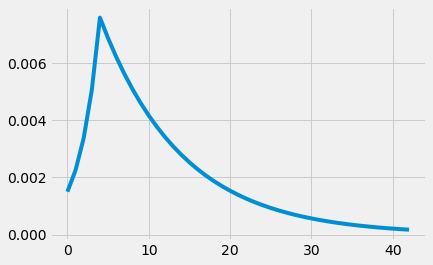

In [66]:
plt.plot(history.history['lr'])

# Submission File

In [67]:
distance_tst = calc_haversine(df_tst.latDeg, df_tst.lngDeg, P_tst[:, 0] + df_tst.latDeg, P_tst[:, 1] + df_tst.lngDeg)
print(f'CV All: {np.percentile(distance_tst, [50, 95])}')

CV All: [0.7284983  3.68900146]


In [68]:
df_tst.sort_values([phone_col, ts_col], inplace=True)
df_tst_smoothed = df_tst.copy()
df_tst_smoothed[lat_col] = df_tst_smoothed[lat_col] + P_tst[:, 0]
df_tst_smoothed[lon_col] = df_tst_smoothed[lon_col] + P_tst[:, 1]
df_tst_smoothed = apply_kf_smoothing(df_tst_smoothed)
distance_tst = calc_haversine(df_tst.latDeg, df_tst.lngDeg, df_tst_smoothed.latDeg, df_tst_smoothed.lngDeg)
print(f'CV All (smoothed): {np.percentile(distance_tst, [50, 95])}')

  0%|          | 0/48 [00:00<?, ?it/s]

CV All (smoothed): [1.4508617  7.54081863]


In [69]:
df_tst_smoothed[[phone_col, ts_col, lat_col, lon_col]].to_csv(submission_file, index=False)